# Calculate fitness for varying parameters and plot heatmaps

In [1]:
%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.metrics import r2_score
import seaborn as sns

## Growth rates with 100% experiments

In [2]:
def get_init(group):
    if "A1" in group or "B1" in group: return 1, 0
    if "A2" in group or "B2" in group: return 0.8, 0.2
    if "A3" in group or "B3" in group: return 0.5, 0.5
    if "A4" in group or "B4" in group: return 0.2, 0.8
    if "A5" in group or "B5" in group: return 0, 1

In [3]:
def game(x, t, g1, g11):
    c1 = x[0]
    c11 = x[1]
    dxdt = [g1 * c1,
            g11 * c11]
    return dxdt

In [4]:
def run(init, g1, g11, true_df):
    max_time = true_df["last_day"].max()
    t = np.arange(0, max_time, 1)
    sol = odeint(game, init, t, args=(g1, g11))
    r2 = 0
    for idx, row in true_df.iterrows():
        true_curve = [np.exp(row["b"]*x+row["d"]) for x in t]
        r2 += r2_score(true_curve, sol[:,0]+sol[:,1])
    return r2/len(true_df)

In [8]:
# Pick which group to look at

# group = "Grp. A1 B6 (100% C1)"
# group = "Grp. A5 B6 (100% C11)"
group = "Grp. B1 nude (100% C1)"
# group = "Grp. B5 nude (100% C11)"

In [6]:
# Define ranges and increment options to calculate
g1_range = [0, 0.3]
g11_range = [0.0, 0.3]
incr = [.01, .02, .05]

In [9]:
c1_init, c11_init = get_init(group)
true_df = pd.read_csv("../../data/scaled_exbd_fit.csv")

In [10]:
all_r2_scores = {} 
for inc in incr:
    g1s = list(np.arange(g1_range[0], g1_range[1], inc))
    g11s = list(np.arange(g11_range[0], g11_range[1], inc))
    # Array of r2 scores for each combination of g1 and g11
    # Each row is [g1, g11, r2 score]
    r2_scores = np.zeros((len(g1s)*len(g11s), 3))
    
    # Loop through all combinations for g1 and g11 and get the r2 score
    for i in range(0, len(g1s)):
        for j in range(0, len(g11s)):
            score = run([c1_init, c11_init], g1s[i], g11s[j], true_df[true_df["group"] == group])
            r2_scores[i*len(g11s)+j] = [g1s[i], g11s[j], score]
    r2_df = pd.DataFrame(r2_scores, columns=["g1", "g11", "r2_score"])
    r2_df = pd.pivot(r2_df, index="g1", columns="g11", values="r2_score")
    r2_df.index = [round(r, 3) for r in r2_df.index]
    r2_df.columns = [round(c, 3) for c in r2_df.columns]
    r2_df = r2_df.where(r2_df >= -10, -10) # Replace anything smaller than -x with -x
    r2_df = r2_df.sort_index(ascending=False)
    # print(r2_df)
    all_r2_scores[inc] = r2_df

In [11]:
all_r2_scores

{0.01:            0.00       0.01       0.02       0.03       0.04       0.05  \
 0.29 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.28 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.27 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.26 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.25 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.24 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.23 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.22 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.21 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.20 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.19 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
 0.18  -8.372573  -8.372573  -8.372573  -8.372573  -8.372573  -8.372573   
 0.17  -3.160291  -

0

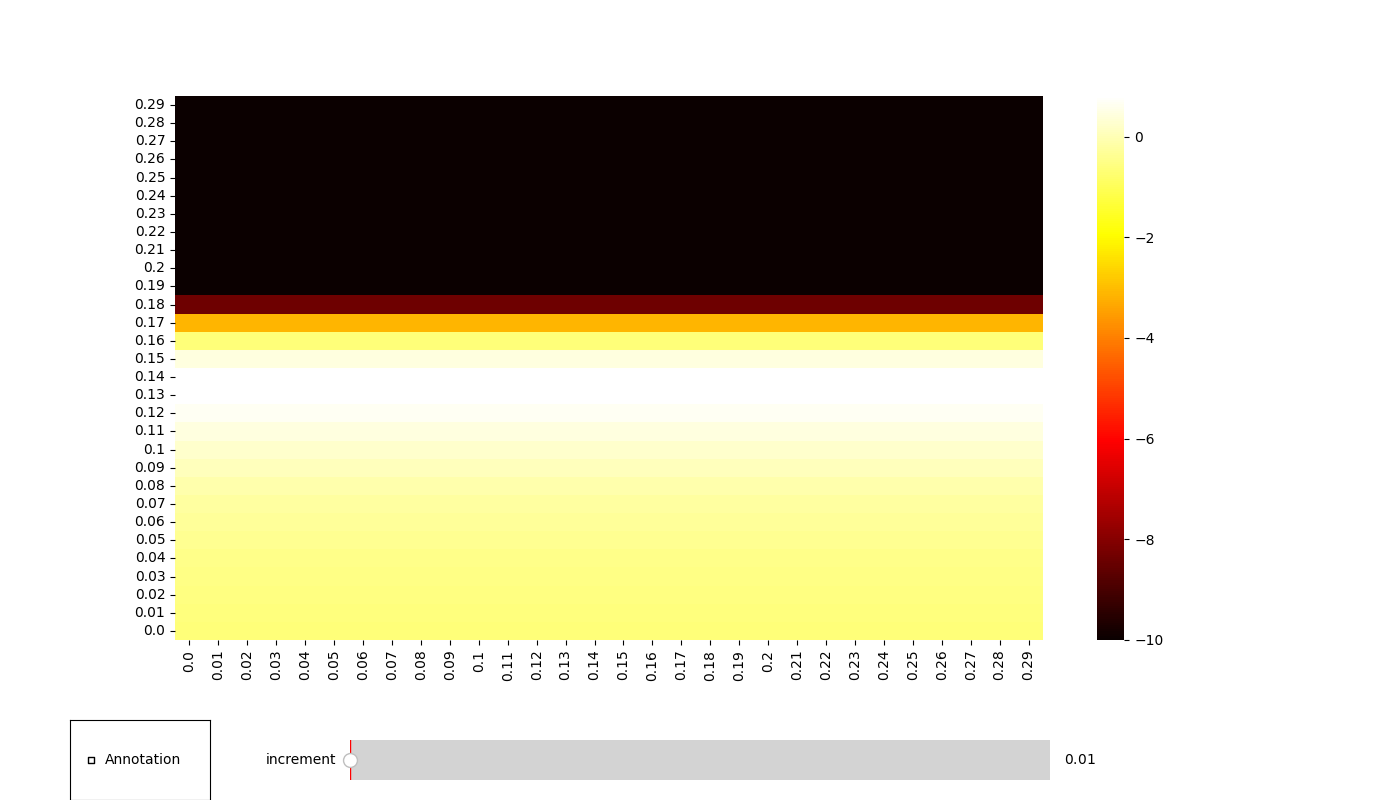

In [12]:
fig, ax = plt.subplots(figsize=(14, 8))
fig.subplots_adjust(bottom=0.2)

sns.heatmap(all_r2_scores[incr[0]], cmap="hot", ax=ax, annot=False)

# Make a horizontal slider
slider_ax = fig.add_axes([.25, 0, .5, .1])
incr_slider = Slider(
    ax=slider_ax,
    label="increment",
    valmin=min(incr),
    valmax=max(incr),
    valinit=incr[0],
    valstep=list(all_r2_scores.keys())
)

button_ax = fig.add_axes([0.05, 0, 0.1, 0.1])
annot_button = CheckButtons(
    ax = button_ax,
    labels=["Annotation"]
)

def update_slider(val):
    ax.cla()
    sns.heatmap(all_r2_scores[val], cmap="hot", ax=ax, annot=annot_button.get_status()[0], cbar=False)
    
def update_button(label):
    x = ax.get_xlim()
    y = ax.get_ylim()
    ax.cla()
    sns.heatmap(all_r2_scores[incr_slider.val], cmap="hot", ax=ax, annot=annot_button.get_status()[0], cbar=False)
    ax.set_xlim(x)
    ax.set_ylim(y)
    
incr_slider.on_changed(update_slider)
annot_button.on_clicked(update_button)

In [13]:
plt.close("all")